In [217]:
from langchain_core.output_parsers import StrOutputParser
from langchain_core.prompts import ChatPromptTemplate
from dotenv import load_dotenv
from langchain_openai import ChatOpenAI
from pydantic import BaseModel, Field
from typing import Literal, TypedDict
from langgraph.graph import StateGraph, START, END
from IPython.display import Image, display, Markdown

load_dotenv()

True

In [218]:
gpt_llm = ChatOpenAI(model="gpt-4o-mini")

In [219]:
class PriorityClassifier(BaseModel):
    """
    Classify the user query into High, Medium, Low priority.
    """
    priority: Literal["High","Medium","Low"] = Field(description="Priority of the user query into High, Medium, Low priority.")

In [220]:
priority_llm = gpt_llm.with_structured_output(PriorityClassifier)

In [221]:
class EmailGenerator(TypedDict):
    query: str
    priority: str
    output_email: str
    email_classifier: str
    final_email: str
    

In [222]:
def query_classifier_node(state: EmailGenerator) -> EmailGenerator:
    prompt = f"Help in classify the user prompt into 'High','Medium','Low' for the {state['query']}"

    response = priority_llm.invoke(prompt)

    return {'priority':response.priority}

In [223]:
def query_classifer_condition(state: EmailGenerator) -> Literal["high_node","medium_node","low_node"]:
    if state["priority"]=="High":
        return "high_node"
    elif state["priority"]=="Medium":
        return "medium_node"
    else:
        return "low_node"


In [224]:
def high_node( state: EmailGenerator)-> EmailGenerator:
    prompt = f"Based on the user query {state['query']} and state of priority {state['priority']}, help in generating the email body with carefully writing each and everything."
    response = gpt_llm.invoke(prompt)

    return {'output_email': response.content}

In [225]:
def medium_node( state: EmailGenerator)-> EmailGenerator:
    prompt = f"Based on the user query {state['query']} and state of priority {state['priority']}, help in generating the email body, keep the tone mellowed and kind"
    response = gpt_llm.invoke(prompt)

    return {'output_email': response.content}

In [226]:
def low_node( state: EmailGenerator)-> EmailGenerator:
    prompt = f"Based on the user query {state['query']} and state of priority {state['priority']}, help in generating the email body, write a not urgent response but user shouldn't feed unimportant."
    response = gpt_llm.invoke(prompt)

    return {'output_email': response.content}

In [227]:
class Email_Classifier(BaseModel):
    """
    Classify the email generated and user query as Yes or No.
    """
    email_classifier: Literal["Yes","No"] = Field(description="Email relevance check as Yes or No")
    

In [228]:
email_llm = gpt_llm.with_structured_output(Email_Classifier)

In [229]:
def email_classifier_node(state: EmailGenerator) -> EmailGenerator:
    """
    You should help in classify the email generated and based on the user query and priority classifier as Yes or No.
    """

    prompt = f"""Help in classify the email generated by the llm - Email \n\n {state['output_email']} for the user query: \n\n {state['query']}. 
    Priority of the user query is {state['priority']}. If mail is not written in bullet point, mark it as No"""

    response = email_llm.invoke(prompt)

    return {'email_classifier':response.email_classifier}
    

In [230]:
def email_classifer_condition(state: EmailGenerator) -> Literal["__end__", "email_regenerator"]:
    if state["email_classifier"]=="Yes":
        return "__end__"
    else:
        return "email_regenerator"


In [231]:
def email_regenerator(state: EmailGenerator) -> EmailGenerator:
    prompt= ChatPromptTemplate.from_messages(
        [
            ("system","You are an evaluator for the email generated by the llm. Your role is to paraphrase the existing email in better way in bullet points and make it more use readable."),
            ("human","Please help in rewrite the email based on the {output_email}")
        ]
    )

    chain = prompt | gpt_llm | StrOutputParser()
    response= chain.invoke({'output_email':state['output_email']})

    return {'final_email':response}

In [232]:
graph = StateGraph(EmailGenerator)

In [233]:
graph = StateGraph(EmailGenerator)

graph.add_node("query_classifier_node", query_classifier_node)
graph.add_node("high_node", high_node)
graph.add_node("medium_node", medium_node)
graph.add_node("low_node", low_node)
graph.add_node("email_classifier_node", email_classifier_node)
graph.add_node("email_regenerator", email_regenerator)

graph.add_edge(START, "query_classifier_node")
graph.add_conditional_edges("query_classifier_node", query_classifer_condition)
graph.add_edge("high_node", "email_classifier_node")
graph.add_edge("medium_node", "email_classifier_node")
graph.add_edge("low_node", "email_classifier_node")
graph.add_conditional_edges("email_classifier_node", email_classifer_condition)
graph.add_edge("email_regenerator", END)

In [234]:
workflow = graph.compile()

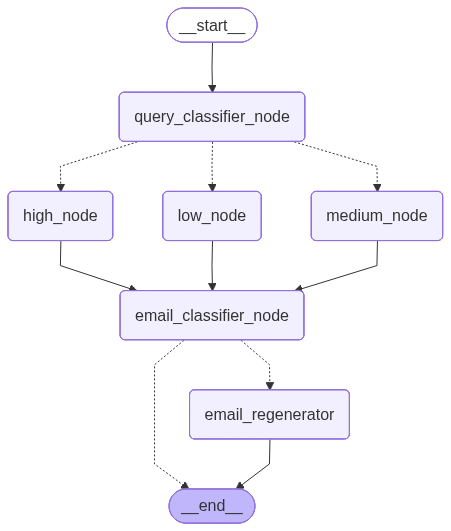

In [235]:
display(Image(workflow.get_graph().draw_mermaid_png()))

In [236]:
result=workflow.invoke({"query":"I have been doing well as the product you have deployed works great."})

In [237]:
result

{'query': 'I have been doing well as the product you have deployed works great.',
 'priority': 'Low',
 'output_email': "Subject: Re: Feedback on Product Performance\n\nDear [User's Name],\n\nThank you for your positive feedback regarding the product! I'm thrilled to hear that it's working well for you. Your experience is important to us, and I appreciate you taking the time to share your thoughts.\n\nWhile I understand that this matter isn't urgent, I want to assure you that your input is valued and will be taken into consideration as we continue to improve our offerings.\n\nIf you have any further feedback or questions in the future, please don't hesitate to reach out. We're here to help!\n\nBest regards,\n\n[Your Name]  \n[Your Position]  \n[Your Company]  \n[Your Contact Information]",
 'email_classifier': 'No',
 'final_email': "Subject: Re: Feedback on Product Performance\n\nDear [User's Name],\n\nI appreciate your positive feedback about our product! Here are some key points to su

In [238]:
Markdown(result['output_email'])

Subject: Re: Feedback on Product Performance

Dear [User's Name],

Thank you for your positive feedback regarding the product! I'm thrilled to hear that it's working well for you. Your experience is important to us, and I appreciate you taking the time to share your thoughts.

While I understand that this matter isn't urgent, I want to assure you that your input is valued and will be taken into consideration as we continue to improve our offerings.

If you have any further feedback or questions in the future, please don't hesitate to reach out. We're here to help!

Best regards,

[Your Name]  
[Your Position]  
[Your Company]  
[Your Contact Information]

In [239]:
Markdown(result['final_email'])

Subject: Re: Feedback on Product Performance

Dear [User's Name],

I appreciate your positive feedback about our product! Here are some key points to summarize our exchange:

- I'm delighted to know that the product is meeting your expectations.
- Your experience is very important to us, and thank you for sharing your thoughts.
- Although your feedback is not urgent, it will be considered as we work on improvements.
- Please feel free to reach out anytime with additional insights or questions.

We're here to assist you!

Best,  
[Your Name]  
[Your Position]  
[Your Company]  
[Your Contact Information]